# Demonstration: dislocation_monopole

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-06-30

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

- - -

## Software

This notebook was tested with:

- LAMMPS (Version 2016-03-11)

- Python (Version 2.7.11)

- Jupyter (Version 1.0.0)

__NOTE__: The potential embedded in this Notebook is a MEAM potential.  Running this script with the embedded potential requires that the LAMMPS executable being used has been built with the optional meam package. 

- - -

## Introduction

This Notebook outlines the code performed by the calc_dislocation_monopole.py calculation and offers a fully self-contained demonstration of the calculation in action.

The calculation script constructs a dislocation monopole system.  The Stroh method is used to solve the anisotropic elasticity solution for a perfectly straight dislocation along the z-axis based on the supplied elastic constants, axes orientation, and Burgers vector. A dislocation is then added to a perfect crystal by shifting the atomic positions according to the Stroh displacement. A boundary region in the xy-plane is identified by changing the atom types of atoms based on their positions. Finally, the atoms in the middle of the system are allowed to relax while the boundary region atoms are held fixed.  If a non-zero anneal temperature is specified, then the system is relaxed at that temperature for 



- - -

## 1. Initial Setup

1. __Necessary Python Libraries__: This is a list of the Python libraries used to run this code. 

2. __Set Working Directory__: Change the directory for performing the calculation.

3. __Input Parameter File__: An embedded copy of the input file read by the script is described.

### 1.1 Necessary Python Libraries

This is a list of the Python libraries used to run this code. 

- [numpy](http://www.numpy.org/) (Version 1.10.04)

- [atomman](https://github.com/usnistgov/atomman) (Version 0.6)

- [DataModelDict](https://github.com/usnistgov/DataModelDict) (Version 0.8)

In [1]:
import os
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import uuid
from copy import deepcopy

import iprPy
from DataModelDict import DataModelDict as DM
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

## 1.2 Set Working Directory

This allows for the working directory of the calculation to be changed.

In [2]:
#Specify working directory
working_dir = 'dislocation_monopole'


#Check if a relative working_dir matches the current directory's name.
#This ensures that recursive directories are not created if this cell is called multiple times.
cwd = os.path.basename(os.getcwd())
if cwd != working_dir:

    #Move to working_dir and create if needed
    working_dir = os.path.abspath(working_dir)
    try:
        os.chdir(working_dir)
    except:
        os.makedirs(working_dir)
        os.chdir(working_dir)

## 1.2 Input Parameter File

This code creates a copy of the input file as read in by the calculation script. Order of the terms doesn't matter. Lines that start with #, or only have terms without values are ignored. 

__NOTE__: The potential_file '2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json' and its associated artifacts are embedded in this Notebook in Sections 2.1 and 2.2, respectively.  The load system_model file 'A1--Cu--fcc.json' is embedded in this Notebook in Section 2.3.  The dislocation_model file '111-edge.json' is embedded in this Notebook in Section 2.4. These embedded files are automatically generated when this Notebook is executed. 

The input file terms used for this calculation are:

Commands

- __lammps_command__: the path to the executable for running LAMMPS on your system.

- __mpi_command__: the command associated with calling LAMMPS to run in parallel on your system (optional).

Potential

- __potential_file__: the path to the LAMMPS-potential data model used by atomman to generate the proper LAMMPS commands for an interatomic potential.
 
- __potential_dir__: the path to the directory containing any potential artifacts (eg. eam setfl files) that are used. Default is '' (working directory for the simulation.)

System Load

- __load__: the style and path to the initial configuration file being read in. The style can be any file type supported by atomman.System.load()
 
- __load_options__: a list of key-value pairs for the optional arguments in atomman.System.load()
 
- __symbols__: a space-delimited list of elemental symbols corresponding to the atom types and potential.  Optional if the elemental information is contained in the file indicated in load.
 
- __box_parameters__: new box parameters to scale the loaded system to. Optional, although should be used if the loaded system is a prototype. 
    
    - three floats: a b c.  Allows for the definintion of orthorhombic lattice parameters.
    
    - six floats: a b c alpha beta gamma.  Allows for the definition of the lattice parameters and angles.

System Manipulation

- __x-axis, y-axis, z-axis__: optional transformation axes for rotating the system. Each vector is given by three space-delimited numbers.  The vectors must be orthogonal to each other.  If the loaded system is cubic these vectors are taken as hkl crystallographic directions and the rotated system is transformed into an orthorhombic box with dimensions given by a\*sqrt(h<sup>2</sup>+k<sup>2</sup>+l<sup>2</sup>) for each axis. 

- __shift__: optional positional shift that is applied to all atoms.  The shift is applied after axis rotation, but before size_mults supersizing.

- __shift_scale__: Boolean flag indicating if the shift is absolute (False), or should be scaled relative to the system's unit cell (True).

- __size_mults__: optional parameters for supersizing the system. This may either be a list of three or six integers.

    - Three integers: mx my mz. The absolute values indicate how many times the system is multiplied along a given box axes and the sign indicates the direction.  
    
    - Six integers: nx px ny py nz pz. This allows for multiplications in both directions for each box axis. The n terms must be less than or equal to zero, and the p terms greater than or equal to zero. 

Dislocation

- __dislocation_model__: the path to the dislocation-monopole-parameters data model containing the parameters necessary for atomman to generate a dislocation.  This model contains the appropriate Burgers vector, along with the system manipulations for the axes orientations and atom shifts associated with a specific dislocation type. 

- __elastic_constants_model__: the path to the elastic-constants data model associated with the loaded system and potential. This contains all of the necessary Cij values.

- __boundary_width__: the width to use in defining the boundary region in the xy-plane.  The boundary region will be at least this thick everythere regardless of the boundary shape.  This value is unitless in that it gets scaled by the system's lattice parameter. Default value is 3.0.

- __boundary_shape__: defines the shape of the active and boundary regions of the system. Options are "circle" and "rect". For "circle", the active region will be cylindrical with center about the z-axis (dislocation line), with a radius such that the boundary region is at least boundary_width thick everywhere.  For "rect", the boundary region is taken as the atoms within boundary_width distance from the x and y bounds.   

- __burgers__: the three components of the Burgers vector.  The values are scaled by the lattice vectors and associated with the unrotated system so that it relates to a crystallographic Burgers vector.  For example, if the Burgers vector is a/2&lt;110&gt;, then use "burgers 0.5 0.5 0.0".

- __C11, C12, etc.__: the Cij values to use for the loaded system and potential. These allow for the elastic constants to be manually specified instead of directly reading in results from another calculation using elastic_constants_model.  The values are associated with the loaded system in its original unrotated orientation. 

Units

- __length_unit__: defines the unit of length for results, and input parameters if not specified. Default is 'angstrom'.

- __energy_unit__: defines the unit of energy for results, and input parameters if not specified. Default is 'eV'.

- __pressure_unit__: defines the unit of pressure for results, and input parameters if not specified. Default is 'GPa'.

- __force_unit__: defines the unit of pressure for results, and input parameters if not specified. Default is 'eV/angstrom'.

Minimization

- __anneal_temperature__: Optional. Temperature at which to anneal the system using NVT for 10000 steps before performing the energy/force minimization. If 0.0, then no temperature annealing occurs before minimizing. Default is 0.0.

- __energy_tolerance__: stopping energy tolerance to use for relaxing the system, i.e. LAMMPS etol. Default is 0.0.

- __force_tolerance__: stopping force tolerance to use for relaxing the system, i.e. LAMMPS ftol. Default is 1e-6 eV/A.

- __maximum_iterations__: integer maximum number of iterations of the minimizer, i.e. LAMMPS maxiter. Default is 100000.         

- __maximum_evaluations__: integer maximum number of evaluations of force/energy, i.e. LAMMPS maxeval. Default is 100000.   

In [3]:
with open('calc_dislocation_monopole.in', 'w') as input_file:
    input_file.write("""
#Run script for calc_point_defect_formation_static.py

#Command lines for LAMMPS (and MPI).
#For lammps_command, exclude passing in a script, i.e. no "-in term" or "< term"
lammps_command              lmp_serial
mpi_command                 

#Paths to the potential data model file, and directory containing potential parameters
potential_file              2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json
potential_dir               

#Initial system configuration to load
load                        system_model A1--Cu--fcc.json
load_options                
symbols                     AlS
box_parameters              4.0502 4.0502 4.0502

#System manipulations
x-axis                      
y-axis                      
z-axis                      
atom_shift                  
size_mults                  -10 10 -10 10 0 1

#Dislocation model (contains axes, shift, and burgers_vector terms)
dislocation_model           111-edge.json

#Elastic constants model (contains all Cij terms)
elastic_constants_model     

#Dislocation parameters
burgers_vector              
boundary_width              3.0
boundary_shape              circle
C11                         110.529
C22                         
C33                         
C12                         60.904
C13                         
C23                         
C44                         28.392
C55                            
C66                         

#Units that input/output values are in
length_unit                 
pressure_unit               
energy_unit                 
force_unit                  

#Run parameters
anneal_temperature         
energy_tolerance            
force_tolerance             
maximum_iterations          
maximum_evaluations      
""")

## 2. Additional Data Files

To make this notebook self-contained, we have embedded a few files.

1. __MEAM Potential.__ Generates library and parameter files for one MEAM potential.

2. __Potential Data Model.__ Collects all input parameters assoiciated with running the MEAM potential in LAMMPS.

3. __Prototype Data Model.__ Generates an instance of the crystal prototype data model used to generate various structures.

4. __Dislocation Monopole Data Model.__ Collects input parameters associated with generating a dislocation monopole associated with the crystal prototype.

### 2.1 MEAM Potential

This generates the library and parameter files associated with the following interatomic potential taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

__2012--Jelinek-B--Al-Si-Mg-Cu-Fe__

__Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys__

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

__Notes__: This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

__Notice__: Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation. 

In [4]:
#Create MEAM library and parameter files for the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential
   
#Create MEAM library file "Jelinek_2012_meamf"
with open('Jelinek_2012_meamf', 'w') as f:
    f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
with open('Jelinek_2012_meam.alsimgcufe', 'w') as f:
    f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")

### 2.2 Potential Data Model

This generates the interatomic potential data model file associated with the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential.

In [5]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
with open('2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json', 'w') as f:
    f.write("""{
    "LAMMPS-potential": {
        "potential": {
            "key": "1515dd80-1984-49de-bc92-d5724059ff56", 
            "id": "2012--Jelinek-B--Al-Si-Mg-Cu-Fe"
        }, 
        "units": "metal", 
        "atom_style": "atomic", 
        "atom": [
            {
                "symbol": "AlS",
                "element": "Al", 
                "mass": 26.9815                
            }, 
            {
                "symbol": "SiS",
                "element": "Si", 
                "mass": 28.086                
            }, 
            {
                "symbol": "MgS", 
                "element": "Mg",
                "mass": 24.305                
            }, 
            {
                "symbol": "CuS", 
                "element": "Cu", 
                "mass": 63.54
            }, 
            {
                "symbol": "FeS", 
                "element": "Fe", 
                "mass": 55.847
            }
        ], 
        "pair_style": {
            "type": "meam"
        }, 
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                }, 
                {
                    "symbolsList": "True"
                }, 
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                }, 
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")

### 2.3 Prototype Data Model

This generates the crystal prototype data model file associated with the fcc crystal prototype.

In [6]:
#Creates an instance of a crystal prototype data model for generating crystal structures.
with open('A1--Cu--fcc.json', 'w') as f:
    f.write("""{
    "crystal-prototype": {
        "identifier": {
            "common": "face-centered cubic", 
            "tag": "fcc", 
            "prototype": "Cu", 
            "Pearson-symbol": "cF4", 
            "Strukturbericht": "A1"
        }, 
        "space-group": {
            "number": 225, 
            "Hermann-Maguin": "F m -3 m", 
            "Schoenflies": "O^5_h", 
            "Wykoff": {
                "letter": "a", 
                "multiplicity": 4
            }
        }, 
        "atomic-system": {
            "cell": {
                "cubic": {
                    "a": {
                        "value": 1.0, 
                        "unit": "scaled"
                    }
                }
            }, 
            "atom": [
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.0, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.5, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.0, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.5, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }
            ]
        }
    }
}""")

## 2.4 Dislocation Monopole Data Model

This generates the dislocation monopole data model associated with an a/2&lt;110&gt; edge dislocation in an fcc crystal.

In [7]:
with open('111-edge.json', 'w') as f:
    f.write("""{
    "dislocation-monopole-parameters": {    
        "dislocation": {
            "key": "d59f2382-17e5-4fbd-b398-407c75e6009a", 
            "id": "111-edge"
        },
        "character": {
            "type": "edge",
            "Burgers-vector": "a/2[ 1, 0,-1]",
            "slip-plane": [ 1, 1, 1],
            "line-direction": [ 1,-2, 1]
        },
        "system-family": "A1--Cu--fcc",
        "atomman-defect-Stroh-parameters": {
            "burgers": [ 0.5, 0.0,-0.5],
            "crystallographic-axes": {
                "x-axis": [ 1, 0,-1],
                "y-axis": [ 1, 1, 1],
                "z-axis": [ 1,-2, 1]
            },
            "shift": [ 0.125, 0.16666666666666667, 0.0]
        }
    }
}""")

# 3. LAMMPS Script Templates and Generation Functions

This section contains template versions of LAMMPS simulation scripts that are used by this calculation and the functions used to fill in the templates.

1. __LAMMPS Templates__: The embedded template file(s) which LAMMPS input scripts are generated from.

2. __Script Generation Functions__: The function(s) that fill in the templates using supplied parameters.

## 3.1 LAMMPS Templates

In [8]:
with open('disl_relax.template', 'w') as f:
    f.write("""#LAMMPS input script for relaxing a dislocation monopole

<atomman_system_info>

<atomman_pair_info>

variable anneal_temp equal <anneal_temp>
variable two_temp equal 2*${anneal_temp}

group move type <group_move>
group hold subtract all move

compute peatom all pe/atom

dump first all custom 100000 atom.* id type x y z c_peatom
dump_modify first format "%d %d %.13e %.13e %.13e %.13e"
thermo_style custom step pe

velocity move create ${two_temp} 9467 mom yes rot yes dist gaussian
fix nomove hold setforce 0.0 0.0 0.0
timestep 0.001
thermo 10000
fix 1 all nvt temp ${anneal_temp} ${anneal_temp} 0.1

run 10000
    
minimize <energy_tolerance> <force_tolerance> <maximum_iterations> <maximum_evaluations>""")
    
with open('disl_relax_notemp.template', 'w') as f:
    f.write("""#LAMMPS input script for relaxing a dislocation monopole

<atomman_system_info>

<atomman_pair_info>

group move type <group_move>
group hold subtract all move

compute peatom all pe/atom

dump first all custom 100000 atom.* id type x y z c_peatom
dump_modify first format "%d %d %.13e %.13e %.13e %.13e"
thermo_style custom step pe

fix nomove hold setforce 0.0 0.0 0.0

minimize <energy_tolerance> <force_tolerance> <maximum_iterations> <maximum_evaluations>""")

## 3.2 Script Generation Functions

In [9]:
def disl_relax_script(template_file, system_info, pair_info, etol = 0.0, ftol = 1e-6, maxiter = 100000, maxeval = 100000, anneal_temp = 0.0, moving_atypes = '1'):
    """Create lammps script for performing a simple energy minimization."""    
    
    with open(template_file) as f:
        template = f.read()
    variable = {'atomman_system_info': system_info,
                'atomman_pair_info':   pair_info,
                'anneal_temp': anneal_temp,
                'group_move': moving_atypes,
                'energy_tolerance': etol, 
                'force_tolerance': ftol,
                'maximum_iterations': maxiter,
                'maximum_evaluations': maxeval}
    return '\n'.join(iprPy.tools.fill_template(template, variable, '<', '>'))

## 4. Python Calculation Function(s)

In [10]:
def boundary_fix(system, symbols, b_width, shape='circle'):
    """Create boundary region by changing atom types. Returns a new system and symbols list."""
    natypes = system.natypes
    atypes = system.atoms_prop(key='atype')
    pos = system.atoms_prop(key='pos')
    
    if shape == 'circle':
        #find x or y bound closest to 0
        smallest_xy = min([abs(system.box.xlo), abs(system.box.xhi),
                           abs(system.box.ylo), abs(system.box.yhi)])
        
        radius = smallest_xy - b_width
        xy_mag = np.linalg.norm(system.atoms_prop(key='pos')[:,:2], axis=1)        
        atypes[xy_mag > radius] += natypes
    
    elif shape == 'rect':
        index = np.unique(np.hstack((np.where(pos[:,0] < system.box.xlo + b_width),
                                     np.where(pos[:,0] > system.box.xhi - b_width),
                                     np.where(pos[:,1] < system.box.ylo + b_width),
                                     np.where(pos[:,1] > system.box.yhi - b_width))))
        atypes[index] += natypes
           
    else:
        raise ValueError("Unknown shape type! Enter 'circle' or 'rect'")

    new_system = deepcopy(system)
    new_system.atoms_prop(key='atype', value=atypes)
    symbols.extend(symbols)
    
    return new_system, symbols

## 5. Run Calculation and Display Results

### 5.1 Run Calculation

In [11]:
__calc_type__ = 'dislocation_monopole'
#Read in parameters from input file
with open('calc_dislocation_monopole.in') as f:
    input_dict = iprPy.calculation_read_input(__calc_type__, f)

In [12]:
__calc_type__ = 'dislocation_monopole'
#Read in parameters from input file
with open('calc_dislocation_monopole.in') as f:
    input_dict = iprPy.calculation_read_input(__calc_type__, f)

#Pull out dislocation-related parameters
burgers = input_dict['ucell'].box.a * np.array(input_dict['burgers'])
b_width = input_dict['ucell'].box.a * np.array(input_dict['boundary_width'])
axes = np.array([input_dict['x-axis'], input_dict['y-axis'], input_dict['z-axis']])                     
C = input_dict['C']

#Read in potential
potential = lmp.Potential(input_dict['potential'], input_dict['potential_dir'])        

#Save initial perfect system
system = deepcopy(input_dict['initial_system'])
system_info = am.lammps.atom_data.dump('base.dat', system, units=potential.units, atom_style=potential.atom_style)

#Solve Stroh method for the dislocation
stroh = am.defect.Stroh(C, burgers, axes=axes)

#Use Stroh displacements to add dislocation monopole to the system
pos = system.atoms_prop(key='pos')
disp = stroh.displacement(pos)
system.atoms_prop(key='pos', value=pos+disp)
system.wrap()

#Add fixed boundary condition
moving_atypes = ' '.join(np.array(range(1, system.natypes+1), dtype=str))
system, symbols = boundary_fix(system, input_dict['symbols'], b_width, input_dict['boundary_shape'])
system_info = am.lammps.atom_data.dump('disl.dat', system, units=potential.units, atom_style=potential.atom_style)

#Run LAMMPS to relax system
pair_info = potential.pair_info(symbols)
if input_dict['anneal_temperature'] == 0.0:
    template_file = 'disl_relax_notemp.template'
else:   
    template_file = 'disl_relax.template'
with open('disl_relax.in', 'w') as f:
    f.write(disl_relax_script(template_file, system_info, pair_info, 
                              etol = input_dict['energy_tolerance'], 
                              ftol = input_dict['force_tolerance'], 
                              maxiter = input_dict['maximum_iterations'], 
                              maxeval = input_dict['maximum_evaluations'], 
                              anneal_temp = input_dict['anneal_temperature'], 
                              moving_atypes = moving_atypes))
output = lmp.run(input_dict['lammps_command'], 'disl_relax.in', input_dict['mpi_command'])
atom_last = 'atom.%i' % output.finds('Step')[-1]
try:
    os.rename(atom_last, 'disl.dump')
except:
    os.remove('disl.dump')
    os.rename(atom_last, 'disl.dump')
os.remove('atom.0')
d_system = lmp.atom_dump.load('disl.dump')

results_dict = {}

results_dict['defect_system'] = d_system

results_dict['pre-ln_factor'] = stroh.preln
results_dict['potential_energy'] =float(output.finds('PotEng')[-1])

#Save data model of results 
results = iprPy.calculation_data_model(__calc_type__, input_dict, results_dict)
with open('results.json', 'w') as f:
    results.json(fp=f, indent=4)

### 5.2 Display results.json

In [13]:
print results.json(indent=4)

{
    "calculation-dislocation-monopole": {
        "calculation": {
            "id": "002183d7-7af0-4635-95e9-0a31a8908e92", 
            "script": "calc_dislocation_monopole", 
            "run-parameter": {
                "size-multipliers": {
                    "a": [
                        -10, 
                        10
                    ], 
                    "b": [
                        -10, 
                        10
                    ], 
                    "c": [
                        0, 
                        1
                    ]
                }, 
                "anneal_temperature": 0.0, 
                "boundary_width": 3.0, 
                "boundary_shape": "circle", 
                "energy_tolerance": 0.0, 
                "force_tolerance": 9.9999999999999995e-07, 
                "maximum_iterations": 100000, 
                "maximum_evaluations": 100000
            }
        }, 
        "potential": {
            "key": "1515dd80-1984-49de-

### 5.3 Print Results

In [14]:
alph = results.find('pre-ln-factor')
print 'Pre ln energy factor = %.4f %s' % (alph['value'], alph['unit'])

print 'Dislocation containing system is saved in disl.dump'

Pre ln energy factor = 0.1673 eV/angstrom
Dislocation containing system is saved in disl.dump


<IPython.core.display.Javascript object>


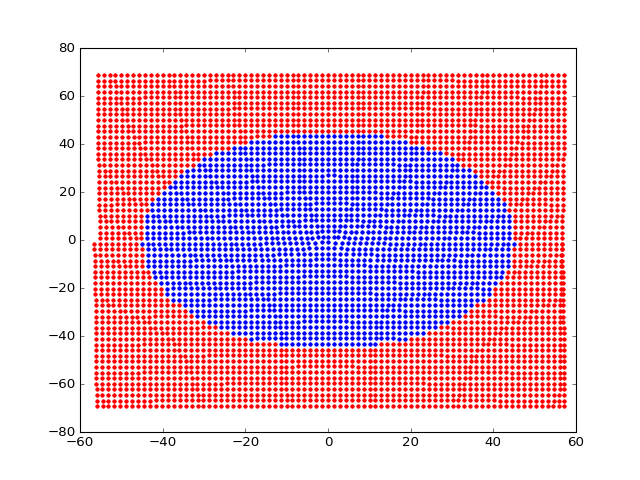

In [15]:
import matplotlib.pyplot as plt
%matplotlib notebook
pos = system.atoms_prop(key='pos')
atype = system.atoms_prop(key='atype')

pos_1 = pos[atype==1]
pos_2 = pos[atype==2]
#plt.xlim(-10, 10)
#plt.ylim(-10, 10)
plt.plot(pos_1[:,0],pos_1[:,1], 'b.')
plt.plot(pos_2[:,0],pos_2[:,1], 'r.')
plt.show()